# Challenge 8

### Fit to Gaussian peak in 2D plane with extended unbinned likelihood, but with systematic error

Again, we keep track of counts in a `(x, y)` plane. Now, we have some information about `B`. We'll solve this exercise with the Bayesian interpretation of probability (instead of frequentist probability). From a practical point of view, this won't change much the way of solving the exercise, since we'll assume the prior probabilities of our parameters to be constant. Therefore, the posterior probability of the theory parameters (`S`, `B`) will basically be the likelihood function, except we'll have to normalize it over the `S`, `B` space to give it a probability meaning.

We have the same data:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from numba import jit

np.random.seed(
    0
)  # We manually set the seed for reproducible results, this is not required

pos_x = np.array([-9.7, -9.3, -6.9, -6.7, -5.7, -5.1, -2.5, -2.5, -2.3, -2.3, -1.9, -1.9, 
                  -1.9, -1.7, -0.7, -0.7, -0.3, -0.1, 0.1, 0.1, 0.3, 0.5, 0.9, 0.9, 0.9,
                  1.3, 1.7, 2.5, 3.3, 4.7, 5.1, 5.5, 5.9, 7.3, 8.3, 8.7, 8.9, 9.1, 9.5, 9.7])

pos_y = np.array([-2.9, -6.1, 9.5, -3.7, -8.9, -9.5, 0.1, 3.3, -2.9, -1.7, 0.1, 0.3, 7.5, 
                 1.9, -1.5, 0.1, -5.9, 6.9, -0.3, 2.1, 2.9, -1.7, -1.5, -0.3, 0.5, -3.3, 
                 6.3, 0.9, -9.3, -4.1, -9.3, -5.7, 7.5, 5.3, -8.7, 0.5, 2.7, 4.9, -9.5, 8.5])

N = len(pos_x) # Total number of events
print(f"Counts registered: {N}")

print("Count coordinates: ")
for i in range(N):
    print(f"({pos_x[i]}, {pos_y[i]}) ", end="")

Counts registered: 40
Count coordinates: 
(-9.7, -2.9) (-9.3, -6.1) (-6.9, 9.5) (-6.7, -3.7) (-5.7, -8.9) (-5.1, -9.5) (-2.5, 0.1) (-2.5, 3.3) (-2.3, -2.9) (-2.3, -1.7) (-1.9, 0.1) (-1.9, 0.3) (-1.9, 7.5) (-1.7, 1.9) (-0.7, -1.5) (-0.7, 0.1) (-0.3, -5.9) (-0.1, 6.9) (0.1, -0.3) (0.1, 2.1) (0.3, 2.9) (0.5, -1.7) (0.9, -1.5) (0.9, -0.3) (0.9, 0.5) (1.3, -3.3) (1.7, 6.3) (2.5, 0.9) (3.3, -9.3) (4.7, -4.1) (5.1, -9.3) (5.5, -5.7) (5.9, 7.5) (7.3, 5.3) (8.3, -8.7) (8.7, 0.5) (8.9, 2.7) (9.1, 4.9) (9.5, -9.5) (9.7, 8.5) 

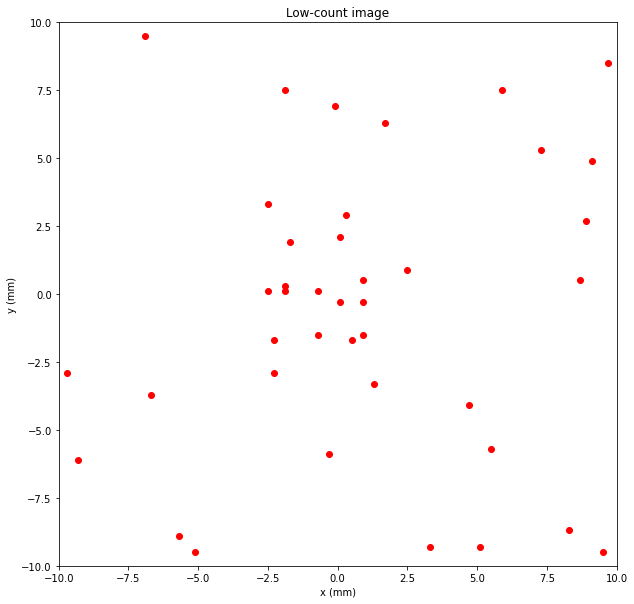

In [2]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

ax.set_title("Low-count image")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

ax.scatter(pos_x, pos_y, color="red")

plt.show()

The distribution of counts for signal over flat background in the plane follows the same 2D Gaussian centered at `(0, 0)` with `sigma2 = 2 mm2`:

In [3]:
@jit
def distr(B, S, x, y, sigma2=2):
    return (B / 400 + (S / 12.5664) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma2)))/(B+S) 

As already mentioned, `B` is known with some systematic uncertainty, `B = 0.05 ± 0.005`. Translating this into our normalised units, `B = 20 ± 2` (multiplying by 400). Since we have a small number of counts in the space, we'll use the unbinned likelihood with an extra Poissonian term (with mean the expected total number of counts, `B+S`) to account for the total number of events registered `N` (again, this means we're assuming the total number `N` is also a random variable and not fixed). We'll incorporate the information about `B` being known by multiplying the likelihood function by a global Gaussian term for `B`, with mean `mean_B = 20` and `sigma_B = 2`. Although in the frequentist approach we'd have followed the same steps, this is more easily justified in Bayesian terms (the information about `B` comes from systematic sources, not the statistical fluctuations of some repeated measurements)

In [4]:
@jit
def gaussian(x, mean, sigma):
    return np.exp(-(x - mean)**2 / (2 * sigma**2)) 

In [5]:
from scipy.stats import poisson

mean_B = 20
sigma_B = 2

def likelihood(B, S):
    res = 1
    for i in range(N):
        res = res*distr(B=B, S=S, x=pos_x[i], y=pos_y[i]) # Unbinned likelihood: product over all the individual events (not bins)
    res = res*poisson(B+S).pmf(N) # Extra Poissonian term with mean B+S
    res = res*gaussian(B, mean_B, sigma_B) # Gaussian term with info about B
    return res

Note that we haven't yet included the normalization over the parameter space of `S`, `B`, and that now we don't apply the `-log()`, since we intend to interpret this as a probability. The normalization factor (integral of the posterior probability = likelihood function in our case, over the parameter space) is just a constant, and doesn't affect the maximum of the likelihood. For practical purposes, we'll calculate this integral (setting cutoffs for `B`, `S`) at the same time we find the values that maximize the likelihood:

In [6]:
def maximize_likelihood(n):
    S_res = 0
    B_res = 0

    max_val = -1e10
    integral = 0
    lower_limit = 0.1 # Instead of 0 to avoid dividing by zero
    upper_limit = 40
    step = (upper_limit - lower_limit) / n
    
    for S in np.linspace(lower_limit, upper_limit, n):
        for B in np.linspace(lower_limit, upper_limit, n):
            like = likelihood(B=B, S=S)
            integral += like
            if like > max_val:
                max_val = like
                B_res = B
                S_res = S
    
    normalization = integral * step**2
    return max_val, B_res, S_res, normalization


max_val, B_max, S_max, normalization = maximize_likelihood(n=100)

print(f"B={B_max:0.1f}, S={S_max:0.1f}, max_likelihood={max_val}, normalization factor={normalization}")

B=21.1, S=14.2, max_likelihood=4.137796075773232e-100, normalization factor=1.9157675238203974e-98


To calculate the confidence intervals, we need the individual posterior probability for `B` and `S`. These are calculated by integrating out `S` (posterior_prob_B) or `B` (posterior_prob_S):

In [7]:
lower_limit = 0.1 # Instead of 0 to avoid dividing by zero
upper_limit = 40
n = 100
step = (upper_limit - lower_limit) / n

posterior_prob_S = np.zeros(n)
posterior_prob_B = np.zeros(n)

i = 0
for S in np.linspace(lower_limit, upper_limit, n):
    integral = 0
    for B in np.linspace(lower_limit, upper_limit, n):
        like = likelihood(B=B, S=S)
        integral += like
    posterior_prob_S[i] = integral * step / normalization
    i += 1

i = 0
for B in np.linspace(lower_limit, upper_limit, n):
    integral = 0
    for S in np.linspace(lower_limit, upper_limit, n):
        like = likelihood(B=B, S=S)
        integral += like
    posterior_prob_B[i] = integral * step / normalization
    i += 1

# We check that integrating out the remaining dimension gives 1 in both cases, as one would expect given we've normalized the 2D probability
suma1 = 0
suma2 = 0
for i in range(n):
    suma1 += posterior_prob_B[i] * step
    suma2 += posterior_prob_S[i] * step
print(suma1)
print(suma2)

0.9999999999999983
0.9999999999999978


We now plot these individual posterior probabilities:

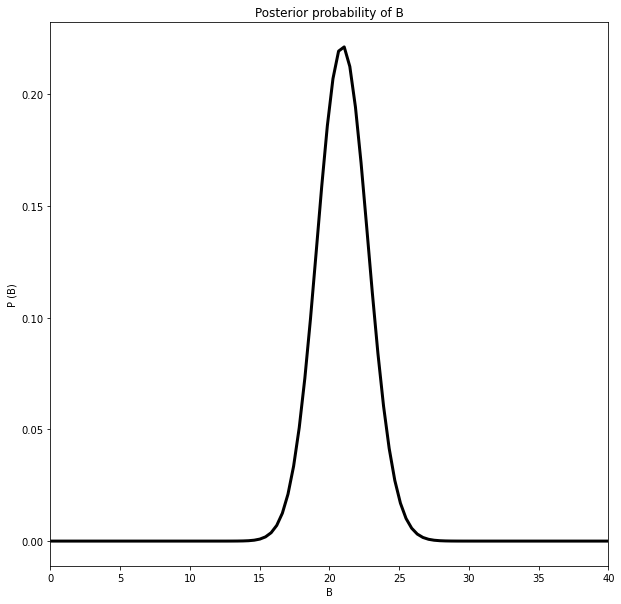

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 40])

ax.set_xlabel("B")
ax.set_ylabel("P (B)")
ax.set_title("Posterior probability of B")

B = np.linspace(0.1, 40, 100)
ax.plot(B, posterior_prob_B, color="black", linewidth=3)

plt.show()

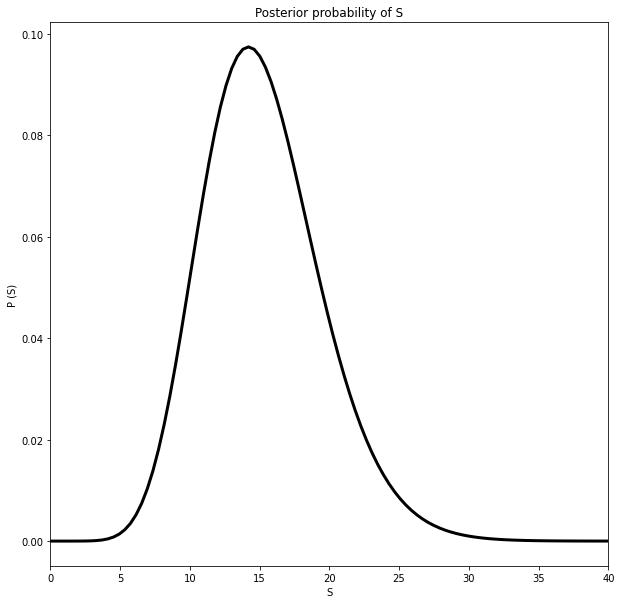

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 40])

ax.set_xlabel("S")
ax.set_ylabel("P (S)")
ax.set_title("Posterior probability of S")

S = np.linspace(0.1, 40, 100)
ax.plot(S, posterior_prob_S, color="black", linewidth=3)

plt.show()

We can now find the uncertainties for both parameters. We'll use our individual posterior probabilities: we find the interval for each of the plots above such that the integral around the minimum is `0.68` (1 sigma case): 

In [10]:
def find_interval(n=100):
    
    sigma = 0.68
    lower_limit = 0.1 # Instead of 0 to avoid dividing by zero
    upper_limit = 40
    step = (upper_limit - lower_limit) / n
    
    # B error: we use posterior_prob_B
    index_B_max = int( (B_max - lower_limit) / step ) # We find the index in posterior_prob_B that corresponds to B_max
    integral = 0
    for i in reversed( range(0, index_B_max) ):
        integral += posterior_prob_B[i] * step
        if integral > sigma/2:
            B_lower_limit = B_max - (lower_limit + i * step)
            break
    
    integral = 0
    for i in range(index_B_max, n):
        integral += posterior_prob_B[i] * step
        if integral > sigma/2:
            B_upper_limit = (lower_limit + i * step) - B_max
            break
    
    B_error = max(B_lower_limit, B_upper_limit) # We ensure an integral >= 0.68
    
    
    # S error: we use posterior_prob_S
    index_S_max = int( (S_max - lower_limit) / step ) # We find the index in posterior_prob_S that corresponds to S_max
    integral = 0
    for i in reversed( range(0, index_S_max) ):
        integral += posterior_prob_S[i] * step
        if integral > sigma/2:
            S_lower_limit = S_max - (lower_limit + i * step)
            break
    
    integral = 0
    for i in range(index_S_max, n):
        integral += posterior_prob_S[i] * step
        if integral > sigma/2:
            S_upper_limit = (lower_limit + i * step) - S_max
            break
    
    S_error = max(S_lower_limit, S_upper_limit) # We ensure an integral >= 0.68
    
    return B_error, S_error


B_error, S_error = find_interval(n=len(posterior_prob_S))

print(f"Uncertainty of B = {B_error:0.1f}, confidence interval: {B_max:0.1f} ± {B_error:0.1f}")
print(f"Uncertainty of S = {S_error:0.1f}, confidence interval: {S_max:0.1f} ± {S_error:0.1f}")

Uncertainty of B = 2.2, confidence interval: 21.1 ± 2.2
Uncertainty of S = 4.9, confidence interval: 14.2 ± 4.9


Note `B` and its uncertainty are in agreement with the values we know they take (we forced them through the Gaussian). Also, the value for `S` is reasonable, since `B+S` is close to `N`.

### Bonus: solving this exercise with frequentist interpretation (basically a copy of Challenge 7)

At the beginning of the exercise, we mentioned we were going to use Bayesian interpretation because it makes more sense when we have systematic errors. However, we could've proceeded exactly in the same way as in Challenge 7, with the only modification being an extra Gaussian global term in the likelihood function. In this approach, we don't care about the normalization factor since the likelihood doesn't have a physical meaning. If we calculate `B_max` and `S_max` (or `B_min` if we use the `-log()` in the likelihood), and we use the scan method to get the confidence interval, we should get the same results.

We define the log-likelihood (the likelihood function in both approaches is the same):

In [11]:
def log_likelihood(B, S):
    return -2*np.log( likelihood(B,S) )

We now minimize it (copied from Challenge 7):

In [12]:
def minimize_loglike(n):
    S_res = 0
    B_res = 0

    log_min = 1e10

    for S in np.linspace(0.1, 40, n):
        for B in np.linspace(0.1, 40, n):
            loglike = log_likelihood(B=B, S=S)
            if loglike < log_min:
                log_min = loglike
                B_res = B
                S_res = S

    return log_min, B_res, S_res


log_min, B_min, S_min = minimize_loglike(n=100)

print(f"B={B_min:0.1f}, S={S_min:0.1f}, logmin={log_min:0.1f}")

B=21.1, S=14.2, logmin=457.7


Now, we plot the likelihood function in two scenarios: fixed `B_min`, varying `S`; varying `B`, fixed `S_min` (Challenge 7 again)

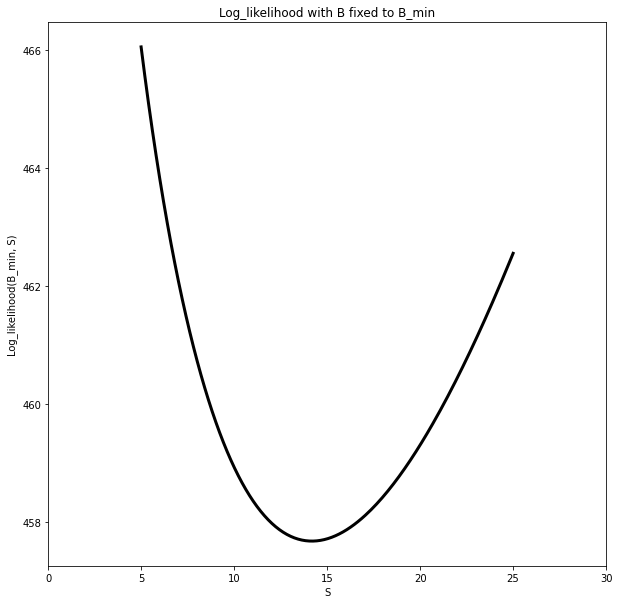

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 30])

ax.set_xlabel("S")
ax.set_ylabel("Log_likelihood(B_min, S)")
ax.set_title("Log_likelihood with B fixed to B_min")

S = np.linspace(5, 25, 200)
ax.plot(S, log_likelihood(B=B_min, S=S), color="black", linewidth=3)

plt.show()

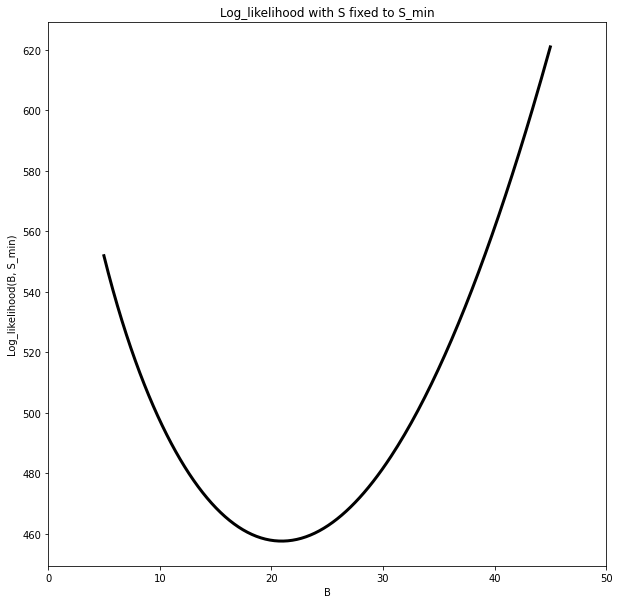

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 50])

ax.set_xlabel("B")
ax.set_ylabel("Log_likelihood(B, S_min)")
ax.set_title("Log_likelihood with S fixed to S_min")

B = np.linspace(5, 45, 200)
ax.plot(B, log_likelihood(B, S=S_min), color="black", linewidth=3)

plt.show()

And we find the interval for each of the plots above such that the change in the log likelihood is `+1` with respect to the minimum (once more, copied from Challenge 7):

In [15]:
def find_interval_frequentist(n=100):
    
    minimum = log_likelihood(B_min, S_min)
    
    # B error: we let B vary
    for i in np.linspace(0.01, B_min, n):
        if log_likelihood(B=i, S=S_min) - minimum < 1:
            B_lower_limit = B_min - i
            break
            
    for i in reversed(np.linspace(B_min, 40, n)):
        if log_likelihood(B=i, S=S_min) - minimum < 1:
            B_upper_limit = i - B_min
            break
    
    B_error = max(B_lower_limit, B_upper_limit)
    
    # S error: we let S vary
    for i in np.linspace(0.01, S_min, n):
        if log_likelihood(B=B_min, S=i) - minimum < 1:
            S_lower_limit = S_min - i
            break
           
    for i in reversed(np.linspace(S_min, 40, n)):
        if log_likelihood(B=B_min, S=i) - minimum < 1:
            S_upper_limit = i - S_min
            break
    
    S_error = max(S_lower_limit, S_upper_limit)
    
    return B_error, S_error


B_error_frequentist, S_error_frequentist = find_interval_frequentist(n=100)

print(f"Uncertainty of B = {B_error_frequentist:0.1f}, confidence interval: {B_min:0.1f} ± {B_error_frequentist:0.1f}")
print(f"Uncertainty of S = {S_error_frequentist:0.1f}, confidence interval: {S_min:0.1f} ± {S_error_frequentist:0.1f}")

Uncertainty of B = 1.9, confidence interval: 21.1 ± 1.9
Uncertainty of S = 4.4, confidence interval: 14.2 ± 4.4


As you can see, the results agree with what we get from our Bayesian probability approach. The minima/maxima are obviously the same (the function we're optimizing is the same) and the intervals are very similar.